# Halo-galaxy connection

### Authors: [Natalí S. M. de Santi](https://natalidesanti.github.io/) and [Christopher Lovell](https://www.christopherlovell.co.uk/)

In this tutorial we are going to see some ideas about how to work with **halo-galaxy connection** in the context of **machine learning** techniques.

## Summary

* 0. Handling data
* 1. Neural Networks

## Running options

* **On the fly:** you can easily work with this complete notebook in `google colab`: 

[![Open this notebook in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/natalidesanti/galevo23-tutorials/blob/tutorial_on_halo-galaxy_connection/week-2/tutorial_on_halo-galaxy_connection/halo-galaxy_connection.ipynb)

* **Own computer:** otherwise you can download the notebook in your own computer and work with it in your own space. Just take care with the library dependencies. 

This current notebook contains the complete tutorial.

Also, you can find notebooks, per item (in the item section above), separetelly, in the directory: `notebooks/` as long with all data (`data/`). These separate notebooks are made to run in local machines but you can modify them to tun it on the fly too!

## 0. Handling data

We are going to see how to read IllustrisTNG data and the
main aspects that we are going to use from this, as a dataset, for the machine
learning session.

We are going to work with **IllustrisTNG** halo/galaxy catalog, from [**CAMELS**](https://camels.readthedocs.io/en/latest/). 
A complete description of the data, as well other user instructions, is given in the [webpage](https://camels.readthedocs.io/en/latest/subfind.html).

### 0.0. Necessary libraries

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns

### 0.1. Getting and reading the data

We will download the catalog from a specif link using `wget`

In [2]:
!wget -q -nc -O fof_subhalo_tab_033.hdf5 https://www.dropbox.com/s/fgkxv5w8qr9v54m/fof_subhalo_tab_033.hdf5?dl=0

The **IllustrisTNG** data is a `.hdf5` file. We can read their content using the library `h5py`, using the `keys` method:

In [3]:
f = h5py.File('fof_subhalo_tab_033.hdf5')
f.keys()

<KeysViewHDF5 ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']>

The catalog specs are given by:

In [4]:
BoxSize      = f['Header'].attrs[u'BoxSize']/1e3    #size of the snapshot in comoving Mpc/h
redshift     = f['Header'].attrs[u'Redshift']       #reshift of the snapshot
scale_factor = f['Header'].attrs[u'Time']           #scale factor
h            = f['Header'].attrs[u'HubbleParam']    #value of the hubble parameter in 100 km/s/(Mpc/h)
Omega_m      = f['Header'].attrs[u'Omega0']         #Omega_matter
Omega_L      = f['Header'].attrs[u'OmegaLambda']    #Omega_baryon

In [5]:
print('Box size:                 %.2f Mpc/h'%BoxSize)
print('snapshot redshift:        %.2f'%redshift)
print('Omega_m:                  %.3f'%Omega_m)
print('Omega_L:                  %.3f'%Omega_L)

Box size:                 25.00 Mpc/h
snapshot redshift:        0.00
Omega_m:                  0.300
Omega_L:                  0.700


Apart from the specifications, the catalogs contain two main groups:

* **Group:** contains the properties of the halos.

* **Subhalos:** contains the properties of the subhalos. Galaxies, are considered as subhalos with stellar mass larger than 0.

In this tutorial we are going to work with both (halos and galaxies). So, le't get some of their properties.

### 0.2. Getting halo and galaxy properties

In [6]:
c = 3.*10**8

# Positions, velocities and masses of the halos
M_h =   f['Group/Group_M_Crit200'][:]*1e10      #Msun/h
R_h =   f['Group/Group_R_Crit200'][:]/c         #kpc/h
V_h  =  f['Group/GroupVel'][:]                  #km/s
V_h =   np.linalg.norm(V_h, axis = 1)
ID_r =  f['Group/GroupFirstSub'][:] #Contains halos without gals as this number = -1
ID_h =  np.arange(0, M_h.shape[0], 1, dtype = float) #It is the ID of the halos, to match the gal cat

# Positions, stellar masses,  of the galaxies
M_g    = f['Subhalo/SubhaloMassType'][:,4]*1e10 #Msun/h
color_g = f['Subhalo/SubhaloStellarPhotometrics'][:]
color_g = color_g[:, 4] - color_g[:, 6]
SFR = f['Subhalo/SubhaloSFR'][:]*1e10 #(Msun/year)/ (10^10 Msun/h)
ID_g = np.array(f['Subhalo/SubhaloGrNr']) #Gals IDs

# close file
f.close()

You can see that the number of halos is not the same as the number of galaxies, because we have halos without and with more than one galaxy (central and satellites):

In [7]:
M_h.shape, M_g.shape

((20131,), (17176,))

Taking only the halos which have galaxies

In [8]:
indexes = np.where( ID_r != -1)[0]
M_h = M_h[indexes]
R_h = R_h[indexes]
V_h = V_h[indexes]
ID_h = ID_h[indexes]

ID_h.shape

(13837,)

Creating the halo and galaxy catalogs

In [9]:
# Halo catalog
data = np.array( [ M_h, R_h, V_h, ID_h ] ).T
columns = [ 'M_h', 'R_h', 'V_h', 'ID' ] 
halos = pd.DataFrame(data = data, columns = columns)
halos.head(3)

,M_h,R_h,V_h,ID
0,4.500575e+13,0.000002,27.004244,0.0
1,1.912689e+13,0.000001,56.368275,1.0
2,2.011009e+13,0.000001,188.867279,2.0


In [10]:
#Galaxy catalog
data = np.array( [ M_g, color_g, SFR, ID_g ] ).T
columns = [ 'M_g', 'color_g', 'SFR_g', 'ID' ] 
gals = pd.DataFrame(data = data, columns = columns)
gals.head(3)

,M_g,color_g,SFR_g,ID
0,4.267894e+11,1.126476,0.000000e+00,0.0
1,2.398532e+10,0.826265,1.699688e+10,0.0
2,1.551164e+10,0.798616,2.204744e+09,0.0


Keeping only central galaxies

In [11]:
gals = gals.drop_duplicates(subset = ['ID'], keep = 'first')

Matching the halo to the galaxy catalogs

In [12]:
df = pd.merge(left = halos, right = gals, left_on = 'ID', right_on = 'ID')
df.shape

(13837, 7)

Cleaning the data

In [13]:
df = df[ df['M_g'] > 0 ] #Considering only galaxies [gals are gals if SM > 0]

In [14]:
#Converting SFR from the non-forming galaxies to have a SFR equal to a Gaussian distribution
df['SFR_g'] = df['SFR_g'].replace(0, 1)
df['SFR_g'] = np.log10(df['SFR_g'])
df.loc[df['SFR_g'] == 0, "SFR_g"] = np.random.normal(7, 0.5, len(df.loc[df["SFR_g"] == 0]))

In [15]:
#Just dropping the ID column because we don't need it anymore
df = df.drop(['ID'], axis = 1)
df.shape

(1514, 6)

Now, let's see some statiscs from these halos/galaxies:

In [16]:
df.describe()

,M_h,R_h,V_h,M_g,color_g,SFR_g
count,1.514000e+03,1.514000e+03,1514.000000,1.514000e+03,1514.000000,1514.000000
mean,2.590867e+11,2.269759e-07,159.914377,3.018712e+09,0.678903,7.622448
std,1.656051e+12,1.490707e-07,84.731841,1.944717e+10,0.192099,1.052962
min,1.443876e+09,6.127277e-08,7.104222,1.739187e+06,-0.794176,5.669010
25%,2.201826e+10,1.519423e-07,100.411592,1.297332e+07,0.638956,6.862470
50%,4.039674e+10,1.860214e-07,144.193092,3.437585e+07,0.700603,7.339203
75%,9.681791e+10,2.489396e-07,204.188789,2.047698e+08,0.764560,8.285613
max,4.500575e+13,1.928402e-06,563.310913,4.267894e+11,1.197241,10.718828


### 0.3. Data-preprocessing

It is important to deal with data in small range, usually, around 1 and 0. So, let's take the $log_{10}$ of the properties

In [17]:
df['M_h'] = np.log10(df['M_h'])
df['R_h'] = np.log10(df['R_h'])
df['V_h'] = np.log10(df['V_h'])
df['M_g'] = np.log10(df['M_g'])

Text(0.5, 0, 'V_h')

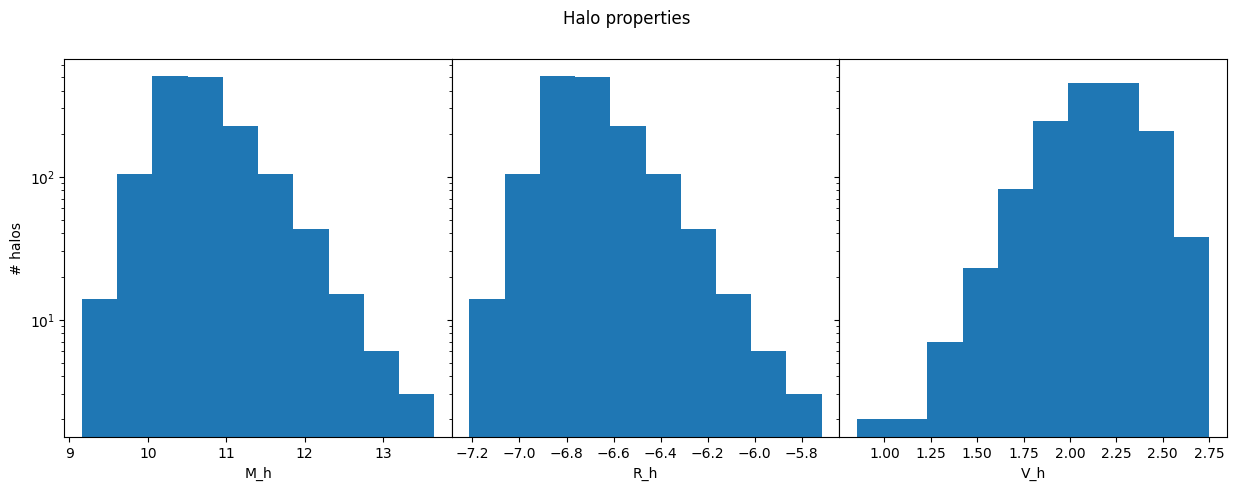

In [18]:
fig = plt.figure(dpi = 100, figsize = (15, 5))
gs = fig.add_gridspec(1, 3, hspace = 0, wspace = 0)
axs = gs.subplots(sharey = True)

fig.suptitle('Halo properties')

axs[0].hist(df['M_h'])
axs[0].set_yscale('log')
axs[0].set_xlabel('M_h')
axs[0].set_ylabel('# halos')

axs[1].hist(df['R_h'])
axs[1].set_yscale('log')
axs[1].set_xlabel('R_h')

axs[2].hist(df['V_h'])
axs[2].set_yscale('log')
axs[2].set_xlabel('V_h')

Text(0.5, 0, 'SFR')

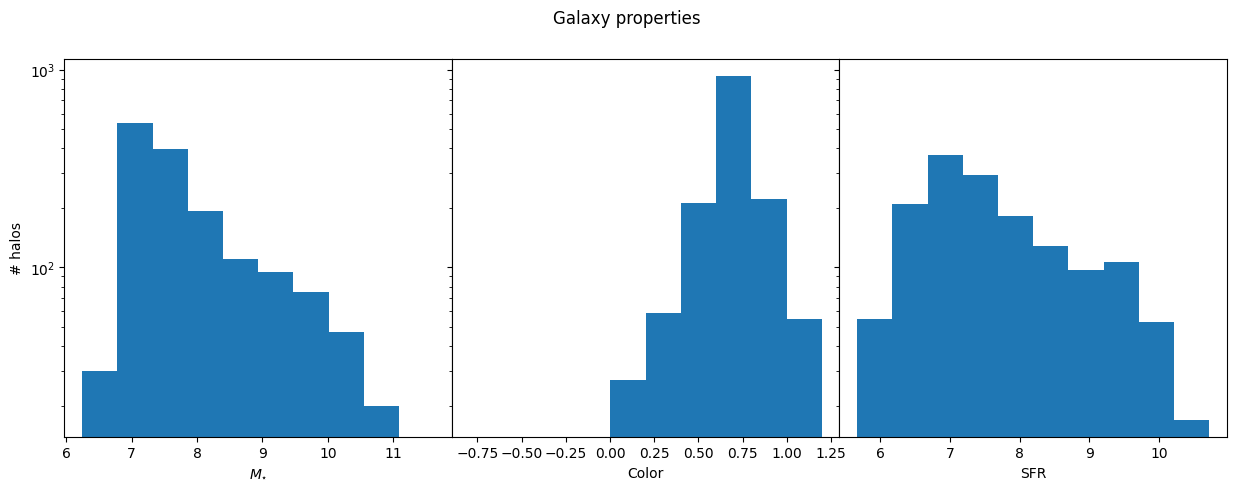

In [19]:
fig = plt.figure(dpi = 100, figsize = (15, 5))
gs = fig.add_gridspec(1, 3, hspace = 0, wspace = 0)
axs = gs.subplots(sharey = True)

fig.suptitle('Galaxy properties')

axs[0].hist(df['M_g'])
axs[0].set_yscale('log')
axs[0].set_xlabel(r'$M_{\star}$')
axs[0].set_ylabel('# halos')

axs[1].hist(df['color_g'])
axs[1].set_yscale('log')
axs[1].set_xlabel('Color')

axs[2].hist(df['SFR_g'])
axs[2].set_yscale('log')
axs[2].set_xlabel('SFR')

### 0.4. Measuring the correlation among halo/galaxy properties

Here we are going to measure the [Pearson Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
\begin{equation}
 PCC = \frac{ \mathrm{cov} (X, Y) }{ \sigma_X \sigma_Y }
\end{equation}

and plotting it as a heatmap of the values.

In [20]:
def correlation_heatmap(df):
    correlations = df.corr(method = 'pearson')

    fig, ax = plt.subplots(figsize = (10,10))
    sns.heatmap(correlations, vmax = 1.0, center = 0, fmt = '.2f',
                square = True, linewidths = .5, annot = True, 
                cbar_kws = {"shrink": .82})
    plt.title('Pearson correlation Heatmap')
    plt.show()
    
    return correlations

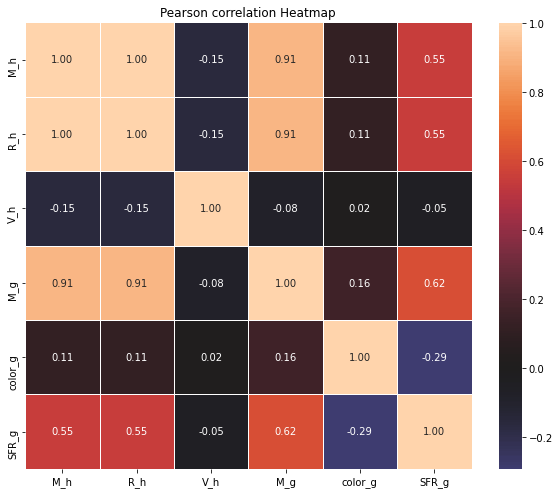

,M_h,R_h,V_h,M_g,color_g,SFR_g
M_h,1.000000,1.000000,-0.154836,0.910068,0.113225,0.549910
R_h,1.000000,1.000000,-0.154837,0.910068,0.113225,0.549910
V_h,-0.154836,-0.154837,1.000000,-0.082602,0.017113,-0.047983
M_g,0.910068,0.910068,-0.082602,1.000000,0.162549,0.615689
color_g,0.113225,0.113225,0.017113,0.162549,1.000000,-0.289915
SFR_g,0.549910,0.549910,-0.047983,0.615689,-0.289915,1.000000


In [21]:
correlation_heatmap(df)

### 0.5. Saving the dataset

In [22]:
#To save in the main directory - COLAB
df.to_csv('halos_and_gals.csv', index = False)

Saving as train and test sets

In [23]:
#Randomizing
df = df.sample(frac = 1, random_state = 42)

In [24]:
#Train and test
total = df.shape[0]
frac = 0.8

df_train = df.iloc[:int(frac*total), :] #train
df_test = df.iloc[int(frac*total):, :] #test

In [25]:
#To save in the main directory - COLAB
df_train.to_csv('train-halos_and_gals.csv', index = False)
df_test.to_csv('test-halos_and_gals.csv', index = False)

## 1. Neural Networks

Now we are going to see how to build a **Neural Network** to predict some galaxy properties, based in some halo properties.

### 1.0. Necessary libraries

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import seaborn as sns
from keras import models
from keras import layers
from keras import regularizers
import os
from scipy.stats import gaussian_kde
from numpy.random import seed
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import set_random_seed
from numpy.random import seed

### 1.1. Reading the data

We are going to work to the data created above

In [27]:
df_train = pd.read_csv('train-halos_and_gals.csv')
df_test = pd.read_csv('test-halos_and_gals.csv')

If, for some reason, you had problems to generate the data you can download it using the following piece of code (you need to remove it from commentary)

In [28]:
# # Downloading it from the cloud
# !wget -q -nc -O test-halos_and_gals.csv https://www.dropbox.com/s/y9rsx6gtjsdr7r1/test-halos_and_gals.csv?dl=0
# !wget -q -nc -O train-halos_and_gals.csv https://www.dropbox.com/s/gncweskcappi81t/train-halos_and_gals.csv?dl=0

# df_train = pd.read_csv('train-halos_and_gals.csv')
# df_test = pd.read_csv('test-halos_and_gals.csv')

Using:
* halos: mass, radius, velocity modulus

To predict
* galaxies: stellar masses

\begin{equation}
 \{ M_h, R_h, V_h \} \Rightarrow M_{\star}
\end{equation}

In [29]:
x_train = np.array([df_train['M_h'], df_train['R_h'], df_train['V_h']]).T
x_test = np.array([df_test['M_h'], df_test['R_h'], df_test['V_h']]).T

y_train = np.array([df_train['M_g']]).T
y_test = np.array([df_test['M_g']]).T

In [30]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1211, 3), (303, 3), (1211, 1), (303, 1))

### 1.2. Pre-processing the data

We will do the following transformation
\begin{equation}
 data \Rightarrow \frac{(data - mean)}{std}
\end{equation}

In [31]:
#Taking mean and std
mean_data = np.mean(x_train, axis = 0)
std_data = np.std(x_train, axis = 0)
mean_data, std_data

(array([10.72031404, -6.69246455,  2.14441201]),
 array([0.57831041, 0.19277028, 0.24073891]))

In [32]:
x_train -= mean_data
x_train /= std_data
x_test -= mean_data
x_test /= std_data

### 1.3. Neural Networks

A **neural network** is a collection of _nodes_ (neurons) that are arranged in a series of **layers**:

![](https://www.tibco.com/sites/tibco/files/media_entity/2021-05/neutral-network-diagram.svg)

Each connection is responsible to give a weight: $\omega_i a_i$ and each layer is a summarization of them, plus a bias $b$, according too:
\begin{equation}
 b_{\mu} + \sum_{\nu} W_{\mu \nu} a_{\nu} .
\end{equation}
Besides, we have another numeric transformation called **activation function**, responsible to perform a non linear transformation of the values of each layer
\begin{equation}
 y_{\mu} = f \left( b_{\mu} + \sum_{\nu} W_{\mu \nu} a_{\nu} \right) ,
\end{equation}
that can assume different forms:

![](https://miro.medium.com/max/1200/1*ZafDv3VUm60Eh10OeJu1vw.png)

During the **training process** these _weights_ are adjusted through **epochs** in order to minimize the difference between the network predictions $y_{pred}$, and the target values $y_{target}$ through the minimization of a **loss function** (that also can assume different forms). In this tutorial we are going to use the **Mean Squared Error** (**MSE**)
\begin{equation}
 MSE = \frac{1}{m} \sum_{i = 1}^m (y_{pred} - y_{target})^2 ,
\end{equation}

### 1.3.1. Defining the model

First, defining the **random seed** to get reproducible results

In [33]:
set_random_seed(42)
seed(42)

Let's define a simple standard model according too:

In [34]:
def base_model():
    model = models.Sequential() 
    model.add(layers.Dense(64, activation = 'relu', 
                           input_shape = (x_train.shape[1],)))
    model.add(layers.Dense(32, activation = 'relu'))
    model.add(layers.Dense(1))
    
    print(model.summary())
    
    model.compile(optimizer = 'Adam', loss = 'mse')
    
    return model

Here you can visualize the model and their details

In [35]:
my_model = base_model()
my_model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,369
Trainable params: 2,369
Non-trainable params: 0
_________________________________________________________________
None


### 1.3.2. Fitting the model

The learning process is made by the `fit` function

In [36]:
#Fitting data
no_epochs = 100
batch_size = 50
validation_split = 0.2
history = my_model.fit(x_train, y_train, epochs = no_epochs, 
                       batch_size = batch_size, 
                       validation_split = validation_split, verbose = False)
history

To see if we don't have over/under fitting we can analyse the validation and training losses

In [37]:
train_loss = history.history['loss']
train_val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

Text(0.5, 0, 'Epochs')

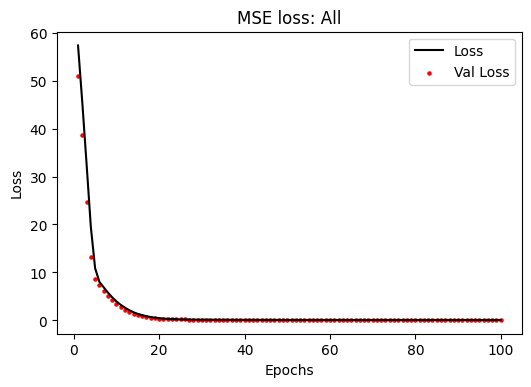

In [38]:
plt.figure(dpi=100)
plt.plot(epochs, train_loss, color = 'black',label = 'Loss')
plt.scatter(epochs, train_val_loss, s = 5, color = 'red', label = 'Val Loss')
plt.legend()  
plt.title('MSE loss: All')
plt.ylabel('Loss')
plt.xlabel('Epochs')

### 1.3.3. Doing the predictions

The predictions are done using the `predict` function

In [39]:
#Predictions
prediction = my_model.predict(x_test)

10/10 [==============================] - 0s 1ms/step


### 1.3.4. Performance

#### a) We check the final performance taking a look of some metric computed over the predictions

In [40]:
#Scores
MSE = mean_squared_error(prediction, y_test)
MSE

0.07860897390975116

#### b) Visualizing the results

Scatter plot

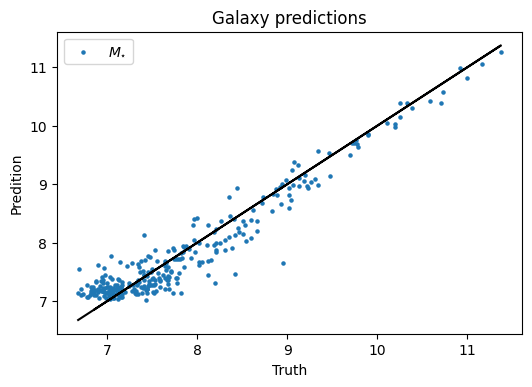

In [41]:
plt.figure(dpi = 100)
plt.title('Galaxy predictions')
plt.scatter(y_test[:, 0], prediction[:, 0], s = 5, color = 'C0', label = '$M_{\star}$')
plt.xlabel(r'Truth')
plt.plot(y_test[:, 0], y_test[:, 0], color = 'black')
plt.ylabel(r'Predition')
plt.legend()

Histogram

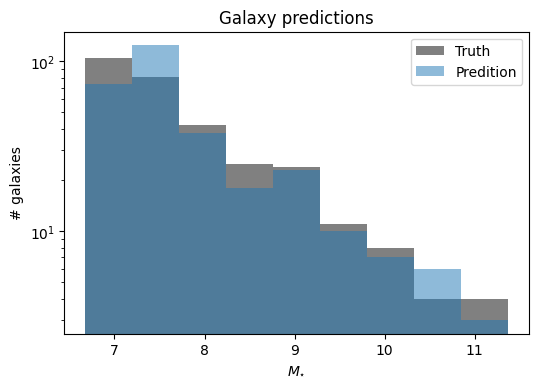

In [42]:
plt.figure(dpi = 100)
plt.title('Galaxy predictions')

bins = np.linspace(np.min(y_test[:, 0]), np.max(y_test[:, 0]), 10)
plt.hist(y_test[:, 0], bins = bins, color = 'gray', label = 'Truth')
plt.hist(prediction[:, 0], bins = bins, color = 'C0', alpha = 0.5, label = 'Predition')
plt.xlabel(r'$M_{\star}$')
plt.ylabel(r'# galaxies')
plt.legend()
plt.yscale('log')

## 1.4. YOUR TURN

Try to create a NN to:

Using:
* halos: mass, radius, velocity modulus

To predict
* 1) galaxies: SFR
* 2) galaxies: color
* 3) galaxies: stellar mass, SFR, color

Try to think in which lines of code you need to change!
Are just the lines corresponding to the predictions?
Are there any issues related to dimensions then?